In [1]:
import numpy as np

from scipy.fft import ifft

from fooof.sim.gen import gen_aperiodic, gen_periodic

from neurodsp.spectral import compute_spectrum
from neurodsp.utils.norm import normalize_sig

from timescales.sim import sim_branching
from timescales.fit import PSD
from timescales.conversions import convert_knee
from timescales.autoreg import compute_ar_spectrum
from timescales.plts import set_default_rc

import matplotlib.pyplot as plt

set_default_rc()

# Figure 2. Bias

Timescale estimation bias arises from oscillations, short duration signals, and dynamic / non-constant timescales. Each of these cases are demonstrated using PSD. The ACF is demonstrated using the inverse Fourier transfrom of the PSD models and simulations.

#### Oscilllatory Bias

In [2]:
# Oscillations
tau = convert_knee(10)
freqs = np.linspace(1, 500, 10000)

pe = gen_periodic(freqs, [10, .5, 2])
ap = gen_aperiodic(freqs, [0, 10, 2])

powers = 10**(ap + pe)
powers /= powers[0]

psd = PSD(freqs, powers)
psd.fit(f_scale=1e-4)

# ACF via iFFT
acf_ap_osc = ifft(psd.powers_fit).real
acf_ap_osc = acf_ap_osc[:len(acf_ap_osc)//2][:200]

acf_osc = ifft(psd.powers).real
acf_osc = acf_osc[:len(acf_osc)//2][:200]
acf_pe_osc = acf_osc - acf_ap_osc
 
rescale = 1/(acf_ap_osc[0] + acf_pe_osc[0])
acf_pe_osc *= rescale
acf_ap_osc *= rescale

lags_osc = np.arange(1, 2*len(acf_ap_osc)+1, 2)
inds_osc = np.where(lags_osc <= 300)
lags_osc = lags_osc[inds_osc]

acf_pe_osc = acf_pe_osc[inds_osc]
acf_ap_osc = acf_ap_osc[inds_osc]

# PSD
psd = PSD(freqs, powers)
psd.fit(f_range=(0, 100), f_scale=1e-4)
ap_fit_osc = psd.powers_fit
knee_ind = np.argmin(np.abs(freqs-psd.knee_freq))

#### Finite Bias

In [3]:
# Finite
np.random.seed(3)
fs = 1000
sig_finite = normalize_sig(sim_branching(1, fs, tau, 20), 0, 1)

freqs_finite, powers_finite = compute_spectrum(sig_finite, fs)
corrs_finite = ifft(powers_finite).real
lags_finite = np.arange(1, 2*len(corrs_finite)+1, 2)

# Trim and rescale ACF
inds_finite = np.where(lags_finite <= 300)
lags_finite = lags_finite[inds_finite]
corrs_finite = corrs_finite[inds_finite]

corrs_finite /= corrs_finite.max()
corrs_finite *= acf_ap_osc[0]

# Trim PSD
inds_finite = np.where((freqs_finite >= 1) & (freqs_finite <= 100))
powers_finite = powers_finite[inds_finite]
powers_finite /= powers_finite[:15].mean()
freqs_finite = freqs_finite[inds_finite]

# AR-PSD and AR-ACF via iFFT
freqs_finite_burg, powers_finite_burg = compute_ar_spectrum(sig_finite, fs, 5)
corrs_finite_burg = ifft(powers_finite_burg).real
corrs_finite_burg = corrs_finite_burg[:len(corrs_finite_burg)//2]
lags_finite_burg = np.arange(1, 2*len(corrs_finite_burg)+1, 2)

# Trim and rescale AR-ACF
inds_burg = np.where(lags_finite_burg <= 300)
lags_finite_burg = lags_finite_burg[inds_burg]
corrs_finite_burg = corrs_finite_burg[inds_burg]

corrs_finite_burg /= corrs_finite_burg.max()
corrs_finite_burg *= acf_ap_osc[0]

# Trim AR-PSD
inds = np.where((freqs_finite_burg >= .5) & (freqs_finite_burg <= 100))[0]
freqs_finite_burg = freqs_finite_burg[inds]
powers_finite_burg = powers_finite_burg[inds]
powers_finite_burg /= powers_finite_burg[0]

#### Dynamic Bias

In [4]:
# Dynamic
knees = np.linspace(5, 15, 100)

# Compute PSD across all knees
freqs_dynamic = np.linspace(1, 1000, 10000)
powers_dynamic = np.array([(1/(k**2 + freqs_dynamic**2)) for k in knees])

corrs_dynamic = np.zeros((len(powers_dynamic), len(powers_dynamic[0])//2))
lags_dynamic = np.arange(1, len(powers_dynamic[0])+1, 2)

# ACF via iFFT
for ind, power in enumerate(powers_dynamic):
    
    acf = ifft(power).real[:len(power)//2]
    acf -= acf.min()
    acf /= acf.max()
    acf *= acf_ap_osc[0]
    
    corrs_dynamic[ind] = acf

# Mean PSD
powers_mid = 1 / (10**2 + freqs_dynamic**2)
powers_mid /= powers_mid[0]

# Mean ACF
corrs_mid = ifft(powers_mid).real[:len(powers_mid)//2]
corrs_mid -= corrs_mid.min()
corrs_mid /= corrs_mid.max()
corrs_mid *= acf_ap_osc[0]

lags_mid = np.arange(1, 2*len(acf_ap_osc)+1, 2)

# Trim PSD and ACF
inds_mid = np.where(lags_mid <= 300)
lags_mid = lags_mid[inds_mid]
corrs_mid = corrs_mid[inds_mid]

inds = np.where(lags_dynamic <= 300)[0]
lags_dynamic = lags_dynamic[inds]
corrs_dynamic = corrs_dynamic[:, inds]

inds = np.where(freqs_dynamic <= 100)[0]
freqs_dynamic = freqs_dynamic[inds]
powers_dynamic = powers_dynamic[:, inds]
powers_mid = powers_mid[inds]

#### Plot

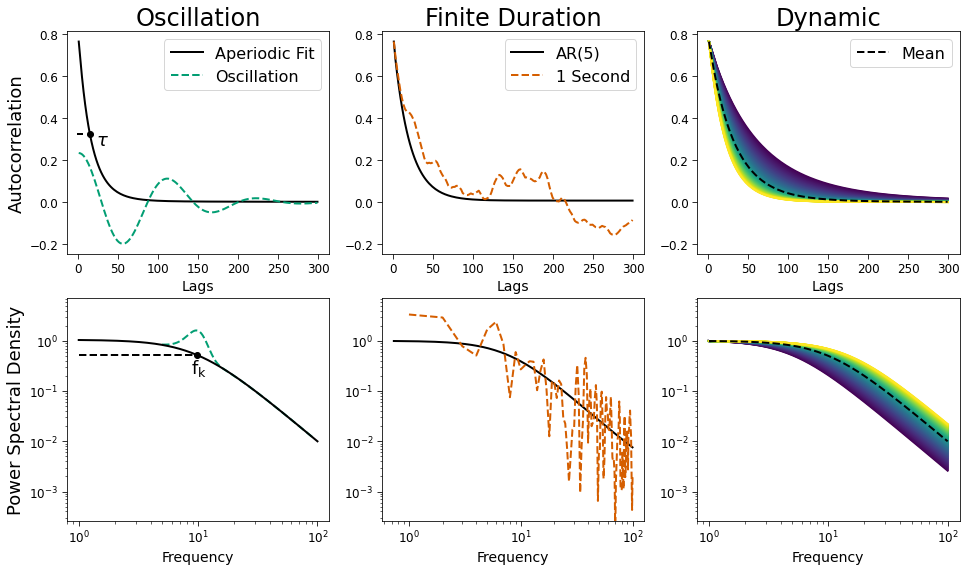

In [14]:
fig, axes = plt.subplots(figsize=(16, 9), nrows=2, ncols=3)

colors_osc = ['k', 'C2']
colors_finite = ['k', 'C3']

# Oscillations - ACF
axes[0][0].plot(lags_osc, acf_ap_osc, color=colors_osc[0], label='Aperiodic Fit')
axes[0][0].plot(lags_osc, acf_pe_osc, ls='--', color=colors_osc[1], label='Oscillation')

ind = np.argmin(np.abs(lags_osc-int(convert_knee(10) * fs)))
axes[0][0].scatter(lags_osc[ind], acf_ap_osc[ind], color='k', zorder=4)
axes[0][0].axhline(acf_ap_osc[ind], .04, .06, ls='--', color='k')
axes[0][0].text(lags_osc[ind]+7, acf_ap_osc[ind]-.05, r'$\tau$', size=18)

# Oscillations - PSD
axes[1][0].loglog(psd.freqs[80:-180], psd.powers[80:-180], color=colors_osc[1], ls='--', label='Oscillation')
axes[1][0].loglog(psd.freqs, psd.powers_fit, color=colors_osc[0], label='Aperiodic')


axes[1][0].scatter(freqs[knee_ind], ap_fit_osc[knee_ind], color='k', zorder=3)
axes[1][0].axhline(ap_fit_osc[knee_ind]-.009, 0.045, .5, color='k', ls='--')
axes[1][0].text(freqs[knee_ind]-1, ap_fit_osc[knee_ind]-.3,
                r'$\mathregular{f_k}$', size=18)

# Finite - ACF
axes[0][1].plot(
    lags_finite_burg, corrs_finite_burg, color=colors_finite[0], label='AR(5)')

axes[0][1].plot(
    lags_finite, corrs_finite, color=colors_finite[1], ls='--', label='1 Second')

# Finite - PSD
axes[1][1].loglog(freqs_finite_burg, powers_finite_burg, color=colors_finite[0], label='AR(5)')
axes[1][1].loglog(freqs_finite, powers_finite, color=colors_finite[1], label='Welch', ls='--')

# Dynamic - ACF
inds = np.where(freqs_dynamic <= 100)

colors = plt.cm.viridis(np.linspace(0, 1, len(knees)))

for _corrs, c in zip(corrs_dynamic, colors):
    axes[0][2].plot(lags_dynamic[:200], _corrs[:200], color=c)
axes[0][2].plot(lags_osc, corrs_mid, color='k', ls='--', label='Mean')  

# Dynamic - PSD
for p, c in zip(powers_dynamic, colors):
    axes[1][2].loglog(freqs_dynamic, p/p[0], color=c)
axes[1][2].plot(freqs_dynamic, powers_mid, color='k', ls='--')   
    
# Axes
ylims = [axes[1][0].get_ylim()[0]-.0075, axes[1][0].get_ylim()[1]+5]
axes[1][0].set_ylim(ylims)
axes[1][1].set_ylim(ylims)
axes[1][2].set_ylim(ylims)

axes[0][1].set_ylim(axes[0][0].get_ylim())
axes[0][2].set_ylim(axes[0][0].get_ylim())

# Titles and labels
xlabsize = 14
axes[0][0].set_xlabel('Lags', size=xlabsize)
axes[0][1].set_xlabel('Lags', size=xlabsize)
axes[0][2].set_xlabel('Lags', size=xlabsize)
axes[1][0].set_xlabel('Frequency', size=xlabsize)
axes[1][1].set_xlabel('Frequency', size=xlabsize)
axes[1][2].set_xlabel('Frequency', size=xlabsize)

axes[0][0].set_ylabel('Autocorrelation')
axes[1][0].set_ylabel('Power Spectral Density')

axes[0][0].set_title('Oscillation')
axes[0][1].set_title('Finite Duration')
axes[0][2].set_title('Dynamic')

axes[0][0].legend(fontsize=16)
axes[0][1].legend(fontsize=16)
axes[0][2].legend(fontsize=16)

plt.savefig('fig02_bias.png', dpi=300, facecolor='w');